## Part 1: London’s underground resilience
### 1. Topological network

In [443]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter

#import the necessary libraries 
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

### Constructing the networks

In [2]:
lg = nx.read_graphml('london.graph.xml')
type(lg)
print(nx.info(lg))

Graph with 401 nodes and 467 edges


/var/folders/nn/h0nhqg0x0dqbf6pbxw9f5gm80000gn/T/ipykernel_41000/3434557228.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(lg))


In [3]:
# To check node attributes:
list(lg.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [4]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in lg.nodes():
    lg.nodes[node]['coords'] = eval(lg.nodes[node]['coords'])
# To check edges attributes:
list(lg.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [5]:
# To check node attributes:
list(lg.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

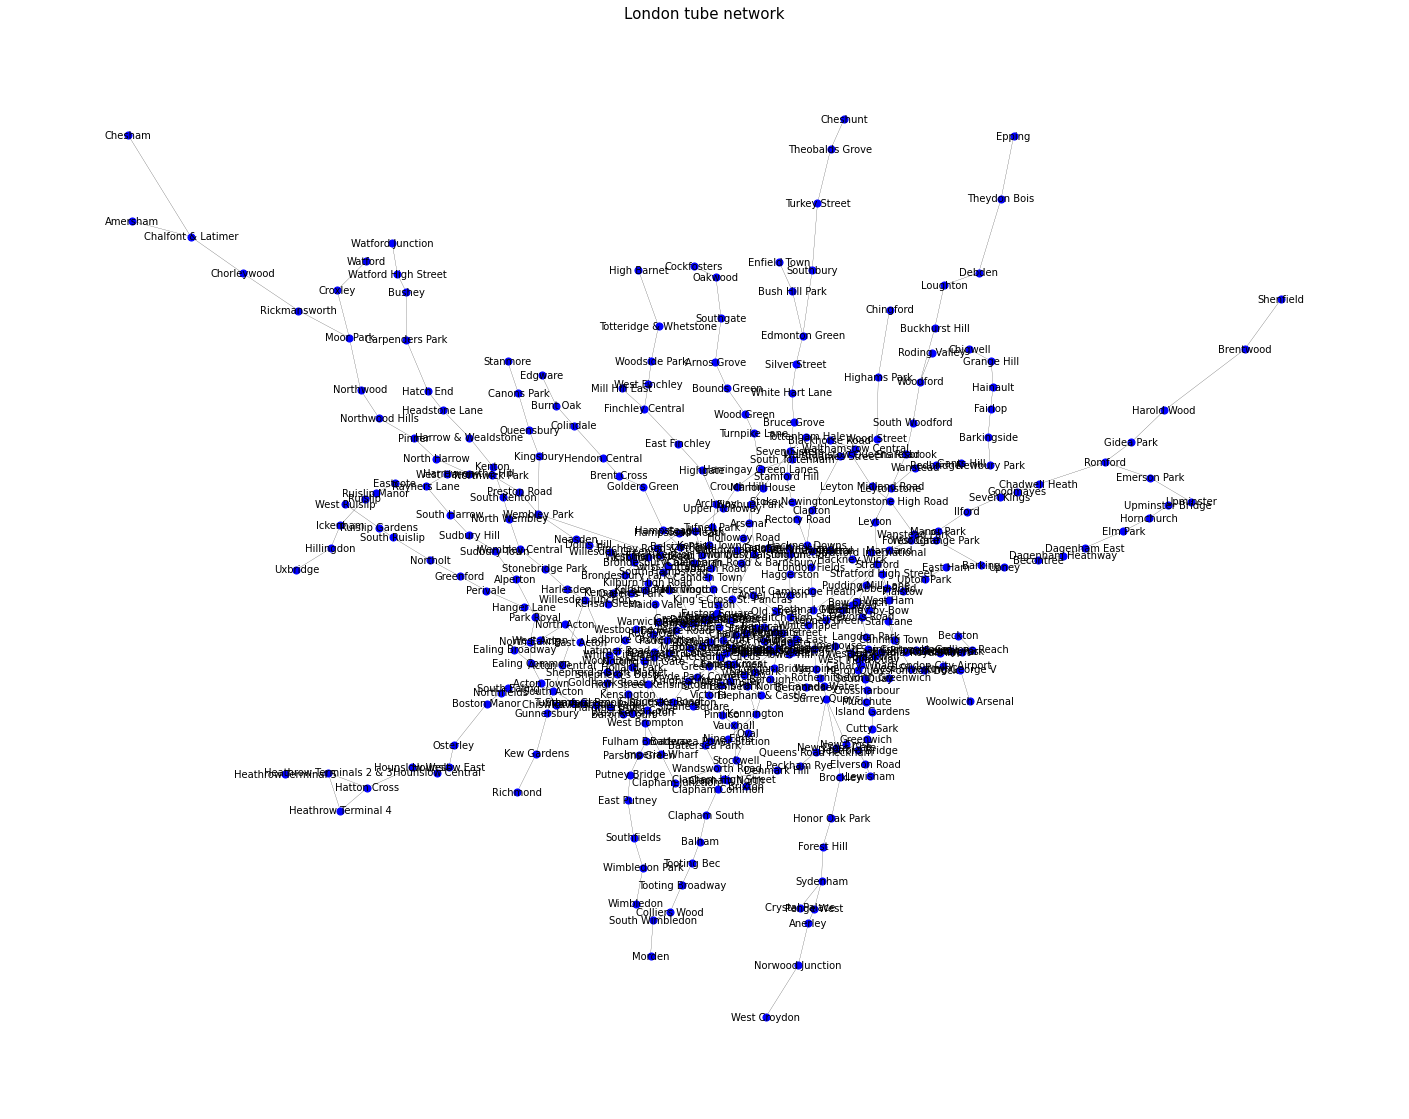

In [6]:
# Let's plot the tube network! 

# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))
pos = nx.get_node_attributes(lg, 'coords')

nx.draw_networkx_nodes(lg,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(lg,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(lg,pos,font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

In [7]:
lg22 = nx.read_graphml('london.graph.xml')
df22 = nx.to_pandas_edgelist(lg).sort_values(by=['length'],ascending= True)
df22[0:10]

,source,target,flows,line_name,length
300,Mansion House,Cannon Street,14345,Circle,248.178706
355,West India Quay,Poplar,2842,DLR,260.862574
28,Canary Wharf,West India Quay,7914,DLR,327.244216
104,Bank and Monument,Cannon Street,21169,Circle,329.312716
297,Embankment,Charing Cross,9127,Bakerloo,340.330820
29,Canary Wharf,Heron Quays,24482,DLR,351.571987
425,Leicester Square,Covent Garden,2025,Piccadilly,365.531299
424,Leicester Square,Piccadilly Circus,3721,Piccadilly,374.691406
368,Blackwall,East India,2582,DLR,391.307206
110,Liverpool Street,Moorgate,41928,Hammersmith & City,434.087449


In [8]:
df22.loc[df22['source'] == "Bank and Monument"]

,source,target,flows,line_name,length
104,Bank and Monument,Cannon Street,21169,Circle,329.312716
107,Bank and Monument,Moorgate,83504,Northern,776.829461
105,Bank and Monument,Tower Hill,19178,Circle,839.730443
103,Bank and Monument,Liverpool Street,160401,Central,841.502684
106,Bank and Monument,Shadwell,21930,DLR,2317.101464


### 1.1. Centrality measures:

### Degree centrality

In [9]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(lg)
nx.set_node_attributes(lg,dict(deg_london),'degree')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=lg.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(lg, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


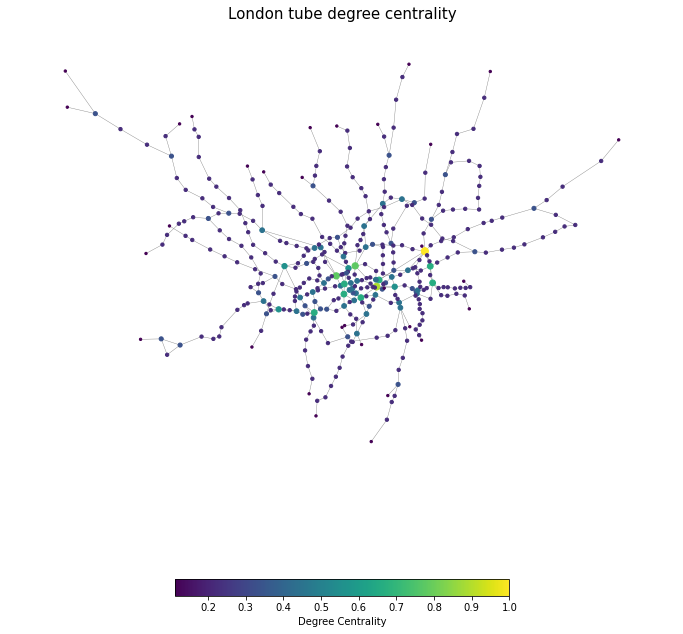

In [10]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in lg.nodes(data=True)]
deg_color=[(i[1]['degree']/(max(degree_values))) for i in lg.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in lg.nodes(data=True)]

# Plot graph
pos=pos
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(lg, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(lg,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

### Topological betweenness centrality, without considering the distance (non-weighted)

In [11]:
bet_london=nx.betweenness_centrality(lg, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(lg,bet_london,'betweenness')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=lg.nodes())
df['betweenness'] = pd.Series(nx.get_node_attributes(lg, 'betweenness'))

df_sorted = df.sort_values(["betweenness"], ascending=False)
df_sorted[0:10]

,betweenness
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


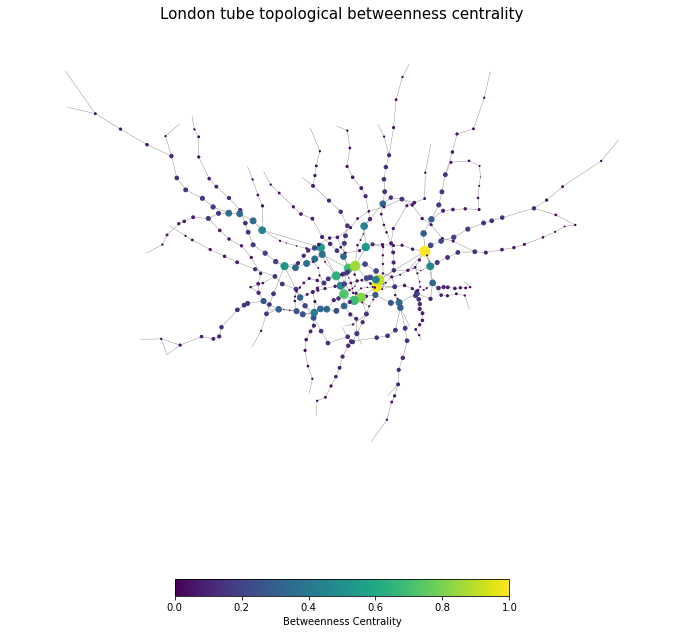

In [12]:
# Lets set colour and size of nodes according to betweenness values
# the number of node between the station 
betweenness_values=[(i[1]['betweenness']) for i in lg.nodes(data=True)]

bet_color=[(i[1]['betweenness']/max(betweenness_values)) 
             for i in lg.nodes(data=True)]
bet_size=[(i[1]['betweenness']/max(betweenness_values))*100 
            for i in lg.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(lg, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(lg, 
                           pos = pos, 
                           node_color= bet_color, 
                           node_size= bet_size)

plt.colorbar(nod,label="Betweenness Centrality",
             orientation="horizontal", 
             shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

### Topological closeness centrality, without considering the distance (non-weighted)

In [13]:
#topological closeness centrality
clos_t=nx.closeness_centrality(lg)
# We can add these values to the nodes attributes:
nx.set_node_attributes(lg,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=lg.nodes())
df['closeness_t'] = pd.Series(nx.get_node_attributes(lg, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


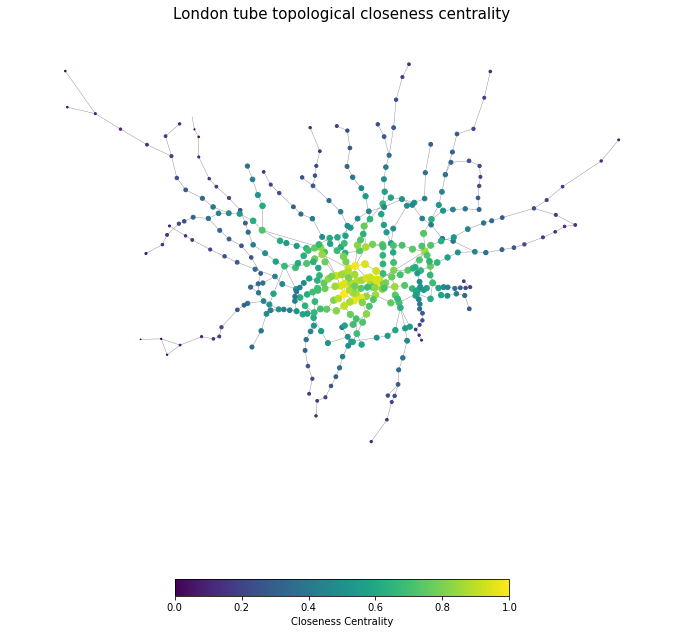

In [14]:
clos_t_val=[(i[1]['closeness_t']) for i in lg.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in lg.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in lg.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(lg, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(lg,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

### 1.2 Impact measures and 1.3 node removal

### A) non-sequential removal:

In [166]:
# lg1=lg.copy()
# lg2=lg.copy()
# lg3=lg.copy()

In [122]:
#gc_deg = []
#gc_bet = []
#gc_clo = []

#ge_deg = []
#ge_bet = []
#ge_clo = []

In [145]:
ge_deg

[0.08891736066510689,
 0.08586164448742485,
 0.08028700838265396,
 0.07570039409751211,
 0.0740361229198828,
 0.07274535237569829,
 0.07094844226118287,
 0.06898194318071488,
 0.06825731584971681,
 0.06338447666647608]

In [134]:
#Remove nodes:
lg1.remove_node("Canning Town")

## giant component
# number of connected components
print (nx.number_connected_components(lg1))
# To comput the size ( number of node) of each component
Subg = [lg1.subgraph(c).copy() 
        for c in nx.connected_components(lg1)]
print ([len(subgraph.nodes) for subgraph in Subg])
gc_deg.append([len(subgraph.nodes) for subgraph in Subg][0])

## global efficiency
print(nx.global_efficiency(lg1))
ge_deg.append(nx.global_efficiency(lg1))

8
[349, 20, 2, 5, 8, 1, 5, 1]
0.06338447666647608


In [163]:
ge_bet

[0.08891736066510689,
 0.08586164448742485,
 0.08496349266423939,
 0.07849775440713821,
 0.07594226578366223,
 0.07415154167648695,
 0.06820564659789057,
 0.06765950327361094,
 0.064700058053009,
 0.06313903700825897]

In [158]:
#Remove nodes:
lg2.remove_node("Finchley Road")

## giant component
# one connected component?
print(nx.is_connected(lg2))
# number of connected components
print (nx.number_connected_components(lg2))
# To comput the size ( number of node) of each component
Subg = [lg2.subgraph(c).copy() 
        for c in nx.connected_components(lg2)]
print ([len(subgraph.nodes) for subgraph in Subg])
gc_bet.append([len(subgraph.nodes) for subgraph in Subg][0])

## global efficiency
print(nx.global_efficiency(lg2))
ge_bet.append(nx.global_efficiency(lg2))

False
7
[339, 2, 20, 2, 5, 1, 22]
0.06313903700825897


In [184]:
ge_clo

[0.09918991960788402,
 0.09487232544791133,
 0.08793385149140875,
 0.08737164566976727,
 0.08485943799789313,
 0.08278135073141742,
 0.08258086417012774,
 0.08260040537396239,
 0.08262233108950982,
 0.08166991436767818]

In [183]:
#Remove nodes:
lg3.remove_node("Moorgate")

## giant component
# one connected component?
print(nx.is_connected(lg3))
# number of connected components
print (nx.number_connected_components(lg3))
# To comput the size ( number of node) of each component
Subg = [lg3.subgraph(c).copy() 
        for c in nx.connected_components(lg3)]
print ([len(subgraph.nodes) for subgraph in Subg])
gc_clo.append([len(subgraph.nodes) for subgraph in Subg][0])

## global efficiency
print(nx.global_efficiency(lg3))
ge_clo.append(nx.global_efficiency(lg3))

False
3
[389, 1, 1]
0.08166991436767818


### A) sequential removal:

In [353]:
#lg4=lg.copy()
#lg5=lg.copy()
#lg6=lg.copy()

In [354]:
#gc_deg_s = []
#gc_bet_s = []
#gc_clo_s = []

#ge_deg_s = []
#ge_bet_s = []
#ge_clo_s = []

In [264]:
#degree
deg_london =nx.degree_centrality(lg4)
nx.set_node_attributes(lg4,dict(deg_london),'degree')

df = pd.DataFrame(index=lg4.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(lg4, 'degree'))

deg_values=[(i[1]['degree']) for i in lg4.nodes(data=True)]
maxdeg =[n for n in lg4.nodes() 
        if lg4.nodes[n]
        ['degree'] == max(deg_values)]

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Willesden Junction,0.012788
Oxford Circus,0.012788
Wembley Park,0.010230
Camden Town,0.010230
Whitechapel,0.010230
Shadwell,0.010230
Liverpool Street,0.010230
Surrey Quays,0.010230
Holborn,0.010230
Tottenham Court Road,0.010230


In [265]:
maxdeg

['Oxford Circus', 'Willesden Junction']

In [266]:
#Remove nodes:
lg4.remove_node("Willesden Junction")
#lg4.remove_nodes_from(maxdeg)
# one connected component?
print(nx.is_connected(lg4))
# number of connected components
print (nx.number_connected_components(lg4))
# To comput the size ( number of node) of each component
Subg = [lg4.subgraph(c).copy() 
        for c in nx.connected_components(lg4)]
print ([len(subgraph.nodes) for subgraph in Subg])
gc_deg_s.append([len(subgraph.nodes) for subgraph in Subg][0])

## global efficiency
print(nx.global_efficiency(lg4))
ge_deg_s.append(nx.global_efficiency(lg4))

False
8
[337, 20, 5, 13, 2, 8, 1, 5]
0.055779283317804275


In [268]:
gc_deg_s

[379, 378, 377, 374, 373, 372, 358, 357, 356, 337]

In [337]:
# betweenness
bet_london=nx.betweenness_centrality(lg5, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(lg5,bet_london,'betweenness')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=lg5.nodes())
df['betweenness'] = pd.Series(nx.get_node_attributes(lg5, 'betweenness'))

btw_values=[(i[1]['betweenness']) for i in lg5.nodes(data=True)]
maxbet =[n for n in lg5.nodes() 
        if lg5.nodes[n]
        ['betweenness'] == max(btw_values)]

df_sorted = df.sort_values(["betweenness"], ascending=False)
df_sorted[0:2]

,betweenness
Baker Street,7505.333333
Paddington,5763.500000


In [338]:
maxbet

['Baker Street']

In [339]:
#Remove nodes:
lg5.remove_nodes_from(maxbet)
#lg5.remove_node("Baker Street")
# one connected component?
print(nx.is_connected(lg5))
# number of connected components
print (nx.number_connected_components(lg5))
# To comput the size ( number of node) of each component
Subg = [lg5.subgraph(c).copy() 
        for c in nx.connected_components(lg5)]
print ([len(subgraph.nodes) for subgraph in Subg])
gc_bet_s.append([len(subgraph.nodes) for subgraph in Subg][0])

## global efficiency
print(nx.global_efficiency(lg5))
ge_bet_s.append(nx.global_efficiency(lg5))

False
7
[170, 147, 20, 29, 2, 1, 22]
0.0381637040943985


In [341]:
ge_bet_s

[0.08891736066510689,
 0.08460293133575152,
 0.08182895253292936,
 0.07767794342812263,
 0.07283234083472483,
 0.053210203984026455,
 0.05165629952389727,
 0.05165629952389727,
 0.0458442134055722,
 0.04163076968121037,
 0.0381637040943985]

In [391]:
#topological closeness centrality
clos_t=nx.closeness_centrality(lg6)
# We can add these values to the nodes attributes:
nx.set_node_attributes(lg6,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=lg6.nodes())
df['closeness_t'] = pd.Series(nx.get_node_attributes(lg6, 'closeness_t'))

clo_values=[(i[1]['closeness_t']) for i in lg6.nodes(data=True)]
maxclo =[n for n in lg6.nodes() 
        if lg6.nodes[n]
        ['closeness_t'] == max(clo_values)]

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:2]

,closeness_t
Oxford Circus,0.050501
Warren Street,0.049899


In [392]:
maxclo

['Oxford Circus']

In [393]:
#Remove nodes:
lg6.remove_nodes_from(maxclo)
#lg6.remove_node("Oxford Circus")
# one connected component?
print(nx.is_connected(lg6))
# number of connected components
print (nx.number_connected_components(lg6))
# To comput the size ( number of node) of each component
Subg = [lg6.subgraph(c).copy() 
        for c in nx.connected_components(lg6)]
print ([len(subgraph.nodes) for subgraph in Subg])
gc_clo_s.append([len(subgraph.nodes) for subgraph in Subg][0])

## global efficiency
print(nx.global_efficiency(lg6))
ge_clo_s.append(nx.global_efficiency(lg6))

False
5
[194, 147, 20, 29, 1]
0.04295771061337044


In [394]:
ge_clo_s

[400, 399, 398, 397, 396, 226, 226, 225, 195, 194]

In [396]:
gc = {'Degree centrality of strategy A':gc_deg,
      'Betweenness centrality of strategy A':gc_bet, 
      'Closeness centrality of strategy A':gc_clo,
      'Degree centrality of strategy B':gc_deg_s,
      'Betweenness centrality of strategy B':gc_bet_s, 
      'Closeness centrality of strategy B':gc_clo_s}
GC = pd.DataFrame (gc)
GC

,Degree centrality of strategy A,Betweenness centrality of strategy A,Closeness centrality of strategy A,Degree centrality of strategy B,Betweenness centrality of strategy B,Closeness centrality of strategy B
0,379,379,400,379,379,400
1,378,378,399,378,378,399
2,377,377,398,377,377,398
3,374,371,397,374,376,397
4,373,370,396,373,375,396
5,371,369,395,372,227,226
6,365,346,394,358,226,226
7,364,345,393,357,196,225
8,363,342,392,356,173,195
9,349,339,389,337,170,194


In [554]:
GC.to_csv('GC.csv')

In [403]:
#ge_bet_s.pop(5)
#ge_bet_s.insert(5, 0.053210203984026455)

In [407]:
ge_bet_s

[0.08891736066510689,
 0.08460293133575152,
 0.08182895253292936,
 0.07767794342812263,
 0.07283234083472483,
 0.053210203984026455,
 0.05165629952389727,
 0.0458442134055722,
 0.04163076968121037,
 0.0381637040943985]

In [425]:
ge = {'Degree centrality of strategy A':ge_deg,
      'Betweenness centrality of strategy A':ge_bet, 
      'Closeness centrality of strategy A':ge_clo,
      'Degree centrality of strategy B':ge_deg_s,
      'Betweenness centrality of strategy B':ge_bet_s, 
      'Closeness centrality of strategy B':ge_clo_s}
GE = pd.DataFrame (ge)
GE

,Degree centrality of strategy A,Betweenness centrality of strategy A,Closeness centrality of strategy A,Degree centrality of strategy B,Betweenness centrality of strategy B,Closeness centrality of strategy B
0,0.088917,0.088917,0.099190,0.088917,0.088917,0.099190
1,0.085862,0.085862,0.094872,0.085862,0.084603,0.094435
2,0.080287,0.084963,0.087934,0.082033,0.081829,0.091816
3,0.075700,0.078498,0.087372,0.075700,0.077678,0.085426
4,0.074036,0.075942,0.084859,0.074036,0.072832,0.080544
5,0.072745,0.074152,0.082781,0.073004,0.053210,0.058101
6,0.070948,0.068206,0.082581,0.067772,0.051656,0.051884
7,0.068982,0.067660,0.082600,0.065936,0.045844,0.050350
8,0.068257,0.064700,0.082622,0.064485,0.041631,0.044395
9,0.063384,0.063139,0.081670,0.055779,0.038164,0.042958


In [555]:
GE.to_csv('GE.csv')

In [562]:
GC = pd.read_csv("GC.csv")
GE = pd.read_csv("GE.csv")

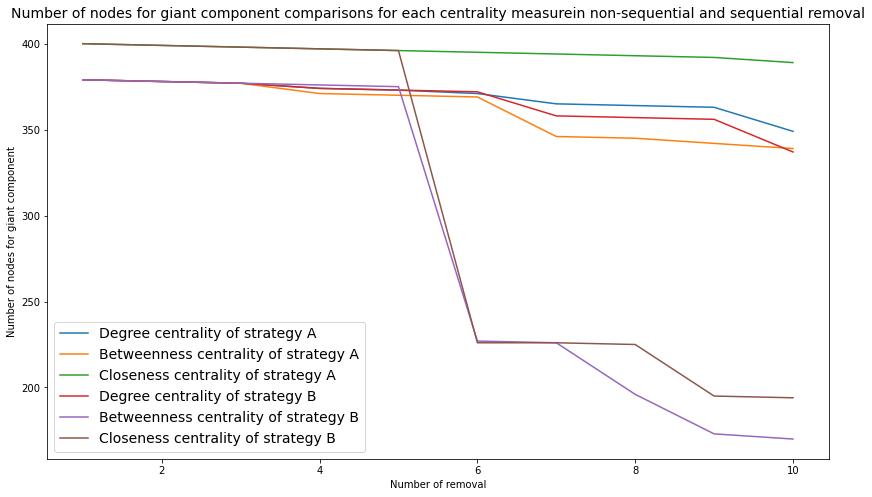

<Figure size 432x288 with 0 Axes>

In [559]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = [1,2,3,4,5,6,7,8,9,10]
  
# plot lines
plt.figure(figsize=(14, 8))
plt.plot(x, GC['Degree centrality of strategy A'], 
         label = 'Degree centrality of strategy A')
plt.plot(x, GC['Betweenness centrality of strategy A'], 
         label = 'Betweenness centrality of strategy A')
plt.plot(x, GC['Closeness centrality of strategy A'], 
         label = 'Closeness centrality of strategy A')
plt.plot(x, GC['Degree centrality of strategy B'], 
         label = 'Degree centrality of strategy B')
plt.plot(x, GC['Betweenness centrality of strategy B'], 
         label = 'Betweenness centrality of strategy B')
plt.plot(x, GC['Closeness centrality of strategy B'], 
         label = 'Closeness centrality of strategy B')

plt.title("Number of nodes for giant component comparisons for each centrality measure\
in non-sequential and sequential removal", fontsize = 14)
plt.xlabel("Number of removal")
plt.ylabel("Number of nodes for giant component")
plt.legend(loc="lower left",fontsize=14)
plt.show()
plt.savefig('GC.png')

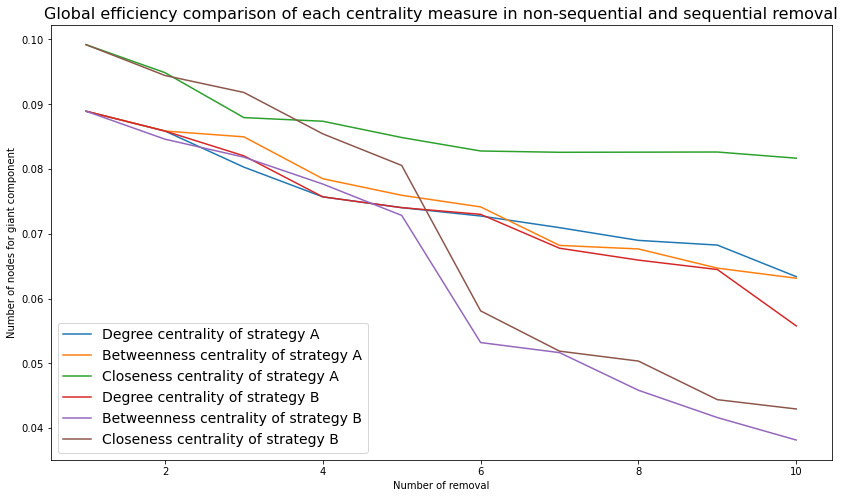

<Figure size 432x288 with 0 Axes>

In [560]:
# create data
x = [1,2,3,4,5,6,7,8,9,10]
  
# plot lines
plt.figure(figsize=(14, 8))
plt.plot(x, GE['Degree centrality of strategy A'], 
         label = 'Degree centrality of strategy A')
plt.plot(x, GE['Betweenness centrality of strategy A'], 
         label = 'Betweenness centrality of strategy A')
plt.plot(x, GE['Closeness centrality of strategy A'], 
         label = 'Closeness centrality of strategy A')
plt.plot(x, GE['Degree centrality of strategy B'], 
         label = 'Degree centrality of strategy B')
plt.plot(x, GE['Betweenness centrality of strategy B'], 
         label = 'Betweenness centrality of strategy B')
plt.plot(x, GE['Closeness centrality of strategy B'], 
         label = 'Closeness centrality of strategy B')

plt.title("Global efficiency comparison of each centrality measure in non-sequential and \
sequential removal", fontsize = 16)
plt.xlabel("Number of removal")
plt.ylabel("Number of nodes for giant component")
plt.legend(loc="lower left", fontsize=14)
plt.show()
plt.savefig('GE.png')

### 2.1 Old vs new measure

### Weighted betweenness centrality

In [18]:
lg7=lg.copy()
bet_london_w=nx.betweenness_centrality(lg7,
                                       weight='flows',
                                       normalized=False)
nx.set_node_attributes(lg7,bet_london_w,'betweenness_w')

df = pd.DataFrame(index=lg7.nodes())
df['betweenness_w'] = pd.Series(nx.get_node_attributes
                                (lg7, 'betweenness_w'))

df_sorted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted[0:10]

,betweenness_w
West Hampstead,28401.50
Gospel Oak,21947.00
Finchley Road & Frognal,21446.00
Hampstead Heath,21372.00
Willesden Junction,19166.50
Leicester Square,17097.75
Brondesbury,16526.00
Brondesbury Park,16411.50
Kensal Rise,16299.75
Blackhorse Road,16091.75


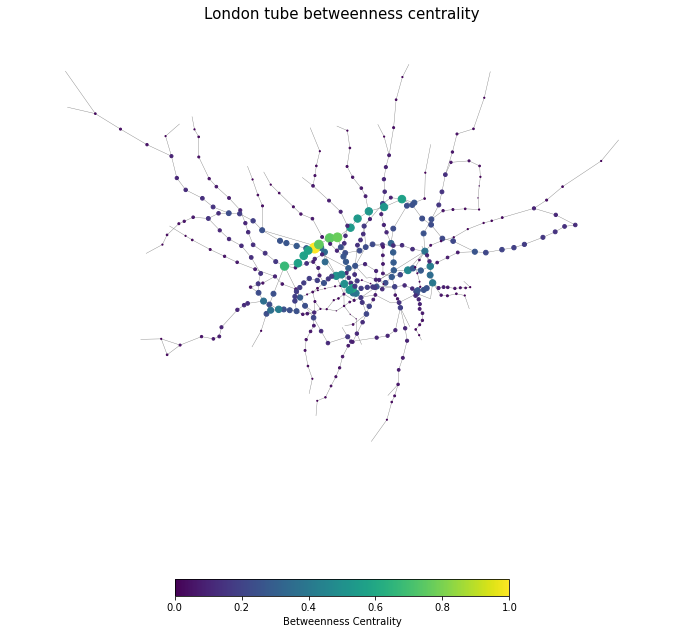

In [19]:
betweenness_w_values=[(i[1]['betweenness_w']) 
                      for i in lg7.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) 
             for i in lg7.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 
            for i in lg7.nodes(data=True)]

# Plot graph
pos=pos
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(lg7, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(lg7,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",
             orientation="horizontal", 
             shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()

### 2.2 Impact measure with flows

In [92]:
from statistics import mean
lg8=lg.copy()
lg9=lg.copy()
## global efficiency
ge1 = nx.global_efficiency(lg8)
print(ge1)

# average_degree
deg_london=nx.degree(lg8)
nx.set_node_attributes(lg8,dict(deg_london),'deg')
lg8_deg=[(i[1]['deg']) for i in lg8.nodes(data=True)]

ave1_deg_london = mean(lg8_deg)
print(ave1_deg_london)

# average_degree_weight
deg_w_london=nx.degree(lg9, weight='flows')
nx.set_node_attributes(lg9,dict(deg_w_london),'deg')
lg9_deg=[(i[1]['deg']) for i in lg9.nodes(data=True)]

ave1_deg_w_london = mean(lg9_deg)
print(ave1_deg_w_london)

0.1012561935972123
2.3291770573566084
49530.40897755611


In [94]:
lg8.remove_node("Stratford")
## global efficiency
ge2 = nx.global_efficiency(lg8)
print(ge2)

# average_degree
deg_london=nx.degree(lg8)
nx.set_node_attributes(lg8,dict(deg_london),'deg')
lg8_deg=[(i[1]['deg']) for i in lg8.nodes(data=True)]

ave2_deg_london = mean(lg8_deg) # k
print(ave2_deg_london)

###########################################################

lg9.remove_node("West Hampstead")
## global efficiency
ge3 = nx.global_efficiency(lg9)
print(ge3)

# average_degree_weight
deg_w_london=nx.degree(lg9,weight='flows')
nx.set_node_attributes(lg9,dict(deg_w_london),'deg')
lg9_deg=[(i[1]['deg']) for i in lg9.nodes(data=True)]

ave2_deg_w_london = mean(lg9_deg) # k
print(ave2_deg_w_london)

0.08891736066510689
2.29
0.10005038744672845
49388.99


In [95]:
print(ge1 - ge2)
print(ge1 - ge3)
print(ave1_deg_london - ave2_deg_london)
print(ave1_deg_w_london - ave2_deg_w_london)

0.012338832932105415
0.0012058061504838513
0.03917705735660837
141.4189775561099


In [96]:
print((ge1 - ge2) / ge1 * 100)
print((ge1 - ge3) / ge1 * 100)
print((ave1_deg_london - ave2_deg_london) / ave1_deg_london * 100)
print((ave1_deg_w_london - ave2_deg_w_london) / ave1_deg_w_london * 100)

12.185756242416284
1.1908468091151398
1.6820128479657341
0.28551950301922924


In [93]:
## global efficiency
print(nx.global_efficiency(lg8))

## averag clustering
ac1 = nx.average_clustering(lg8, weight=None)
ac2 = nx.average_clustering(lg9, weight="flows")
print(ac1)
print(ac2)

0.1012561935972123
0.030382377389858693
0.0015791877116043112


In [97]:
## global efficiency
print(nx.global_efficiency(lg8))
print(nx.global_efficiency(lg9))

## averag clustering
ac3 = nx.average_clustering(lg8, weight=None)
ac4 = nx.average_clustering(lg9, weight="flows")
print(ac3)
print(ac4)

0.08891736066510689
0.10005038744672845
0.030625000000000003
0.001583135680883322


In [98]:
print((ac1 - ac3) / ac1 * 100)
print((ac2 - ac4) / ac2 * 100)

-0.7985636114910979
-0.2500000000000019
